In [2]:
import numpy as np

import torch
import torch.nn as nn

import jax.numpy as jnp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm


from kernels import *
from utils import *

In [39]:
def signal(mu, total_time, dt=1, seed=None):
    num_trajectories = len(mu)
    num_steps = int(total_time / dt)

    rho = np.random.normal(loc=0, scale=0.1, size=(num_trajectories, num_steps))
    x = mu[:, None] + rho
    
    p = np.sign(mu)                                                                          #p is of shape K, with -1 or 1 based on sign(mu_k)
    x = x[:, :, None]                                                                       #x is K=mu="batch_sz", T, 1
    return torch.tensor(x, dtype=torch.float32), torch.tensor(p, dtype=torch.float32)

def mse_loss(z_all, p):
    zeros = torch.zeros_like(p)
    p_all = torch.stack([zeros, p]).T
    z_comp = torch.stack([z_all[:,0].squeeze(), z_all[:,-1].squeeze()]).T
    return torch.mean((z_comp - p_all) ** 2)

def cross_entropy_loss(z_all, p, model, l2_lambda):
    criterion = nn.CrossEntropyLoss()
    
    #zeros = torch.zeros_like(p)
    #p_all = torch.stack([zeros, p]).T
    #z_comp = torch.stack([z_all[:, 0].squeeze(), z_all[:, -1].squeeze()]).T
    
    loss = criterion( z_all[:, -1].squeeze(), p)
    
    l2_reg = sum(param.pow(2).sum() for param in model.parameters())
    loss += l2_lambda * l2_reg
    
    return loss
    
class DriftDiffusionRNN(torch.nn.Module):
    def __init__(self, hidden_size, input_size, output_size):
        super(DriftDiffusionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNNCell(input_size, hidden_size, nonlinearity='tanh')       #1 --> H=100
        self.fc = torch.nn.Linear(hidden_size, output_size)                             #H=100 --> 1

    def forward(self, x):
        h_i = torch.zeros(x.shape[0], self.hidden_size)                                 #h_i = [K, H=100]
        ls_h_i = []
        ls_z = []
        for i in range(x.shape[1]):
            h_i = self.rnn(x[:, i, :], h_i)
            ls_h_i.append(h_i)
            z = self.fc(h_i)                                                            #momentary evidence z [K,]
            ls_z.append(z)
        #z = torch.tanh(z)
        z_all = torch.stack(ls_z, dim=1)                                                #K, T, 1                                                         
        return z_all, ls_h_i

def train_model(model, optimizer, mu, iterations=10, total_time=50, save_path = 'model.pth'):
    model.train()
    ls_loss = []
    for iter in range(iterations):
        x, p = signal(mu, total_time)
        optimizer.zero_grad()
        z_all, ls_h_i = model(x)  
        loss = mse_loss(z_all, p)
        #loss = cross_entropy_loss(z_all, p, model, l2_lambda= 1e-4)
        loss.backward()
        optimizer.step()

        ls_loss.append(loss.item())
        print(f'Iteration [{iter+1}/{iterations}], Loss: {loss.item():.4f}')
    #torch.save(model.state_dict(), save_path)
    return ls_loss, z_all

mu = np.array([-0.64, -0.32, -0.16, -0.08, -0.04, 0.04, 0.08, 0.16, 0.32, 0.64])  

lr=1e-3
total_time=100
iterations=500
model = DriftDiffusionRNN(hidden_size=100, input_size=1, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

ls_loss, z_all = train_model(model, optimizer, mu,  iterations=iterations, total_time=total_time)




Iteration [1/500], Loss: 0.5169
Iteration [2/500], Loss: 0.5053
Iteration [3/500], Loss: 0.4946
Iteration [4/500], Loss: 0.4835
Iteration [5/500], Loss: 0.4737
Iteration [6/500], Loss: 0.4664
Iteration [7/500], Loss: 0.4513
Iteration [8/500], Loss: 0.4383
Iteration [9/500], Loss: 0.4231
Iteration [10/500], Loss: 0.3999
Iteration [11/500], Loss: 0.3752
Iteration [12/500], Loss: 0.3320
Iteration [13/500], Loss: 0.2615
Iteration [14/500], Loss: 0.1306
Iteration [15/500], Loss: 0.0418
Iteration [16/500], Loss: 0.0945
Iteration [17/500], Loss: 0.6031
Iteration [18/500], Loss: 0.4820
Iteration [19/500], Loss: 0.4670
Iteration [20/500], Loss: 0.2633
Iteration [21/500], Loss: 0.2329
Iteration [22/500], Loss: 0.2603
Iteration [23/500], Loss: 0.2913
Iteration [24/500], Loss: 0.3182
Iteration [25/500], Loss: 0.3138
Iteration [26/500], Loss: 0.3262
Iteration [27/500], Loss: 0.3367
Iteration [28/500], Loss: 0.3580
Iteration [29/500], Loss: 0.3292
Iteration [30/500], Loss: 0.3422
Iteration [31/500],

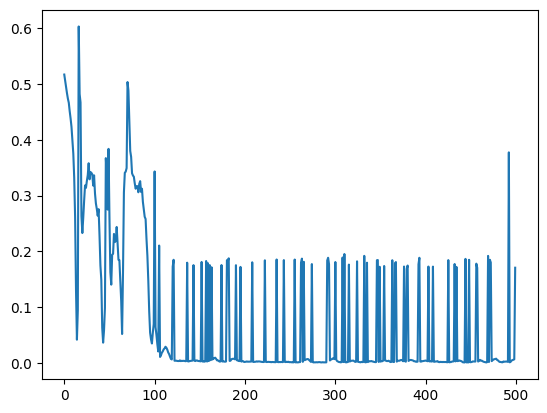

In [40]:
plt.plot(ls_loss)

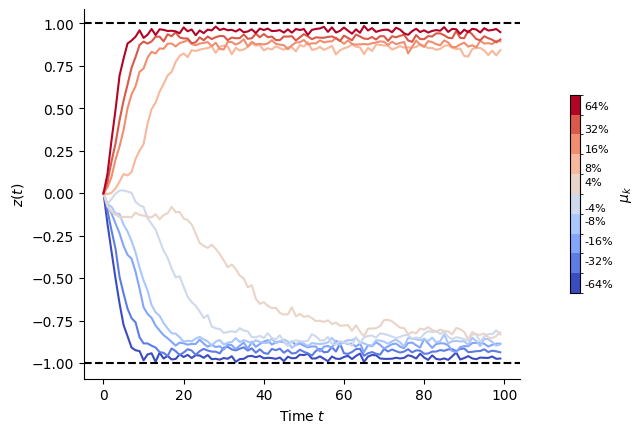

In [41]:
# for i in range(10):
#     plt.plot(z_all[i, :].detach().numpy())

fig, ax = plt.subplots()
boundaries = np.concatenate(([mu[0] - (mu[1] - mu[0])/2], (mu[:-1] + mu[1:])/2, [mu[-1] + (mu[-1] - mu[-2])/2]))
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(mu))
cmap = plt.get_cmap('coolwarm', len(mu))

for i, m in enumerate(mu):
    ax.plot(z_all[i, :].detach().numpy(), color=cmap(norm(m)))

ax.axhline(y=1, color='black', linestyle='--')
ax.axhline(y=-1, color='black', linestyle='--')
ax.set_xlabel('Time $t$')
ax.set_ylabel(r'$z(t)$')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
 
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1, ticks=mu)
cbar.ax.tick_params(size=0) 
cbar.set_label('$\mu_k$')
cbar.set_ticklabels([f'{100*m:.0f}%' for m in mu], fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [87]:
def add_low_rank_noise(X, key1, key2, proj_dims = 3, sigma = 1, l2_=0.1 ):
    K, N, T = X.shape    
    B = random.normal(key1, (N, proj_dims))
    B, _ = jnp.linalg.qr(B)

    time_points = jnp.linspace(0, 1, T)[None, :]
    cov_matrix = K_X_Y_squared_exponential(time_points, time_points, l2=l2_)
    L = jnp.linalg.cholesky(cov_matrix + jnp.identity(T) * 1e-5)

    epsilon_t_uncorr = random.normal(key2, (K, T, proj_dims)) * sigma  
    epsilon_t = jnp.einsum("ts,ksd->ktd", L, epsilon_t_uncorr)
    noise = jnp.einsum('ktd,nd->knt', epsilon_t, B)             
    
    X += noise                                                   
    return X

seed = 42
key = random.PRNGKey(seed)
key1, key2, key3, key4, key5 = random.split(key, 5)

x, p = signal(mu, total_time=100)
z_all, ls_h_i = model(x)

ls_X = [jnp.array(tensor.detach().numpy()) for tensor in ls_h_i]
X = jnp.stack(ls_X, axis=1).swapaxes(1,2) 
X, _ = pre_processing(X, soft_normalize=None, center=False, num_pcs=10)
X = X[:,:,:20]
X = add_low_rank_noise(X, key1, key2)
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)          
A = A.reshape(N,-1)   



Iteration 0, S: 0.037678588181734085, S_ratio: 0.25126126408576965
Iteration 10, S: 0.3340512216091156, S_ratio: 0.4052039086818695
Iteration 20, S: 0.8861790895462036, S_ratio: 0.4801118075847626
Iteration 30, S: 1.3942044973373413, S_ratio: 0.49959808588027954
Iteration 40, S: 2.4413702487945557, S_ratio: 0.40047115087509155
Iteration 50, S: 3.2940170764923096, S_ratio: 0.376874715089798
Iteration 60, S: 4.333949565887451, S_ratio: 0.32279351353645325
Iteration 70, S: 5.415095806121826, S_ratio: 0.2739504873752594
Iteration 80, S: 4.938054084777832, S_ratio: 0.27696388959884644
Iteration 90, S: 6.798882007598877, S_ratio: 0.24574212729930878
Iteration 100, S: 5.983615398406982, S_ratio: 0.2589383125305176
Iteration 110, S: 6.815199851989746, S_ratio: 0.25830164551734924
Iteration 120, S: 5.995632648468018, S_ratio: 0.24747399985790253
Iteration 130, S: 6.02064847946167, S_ratio: 0.2657608687877655
Iteration 140, S: 6.970705986022949, S_ratio: 0.25878891348838806
Iteration 150, S: 6.0

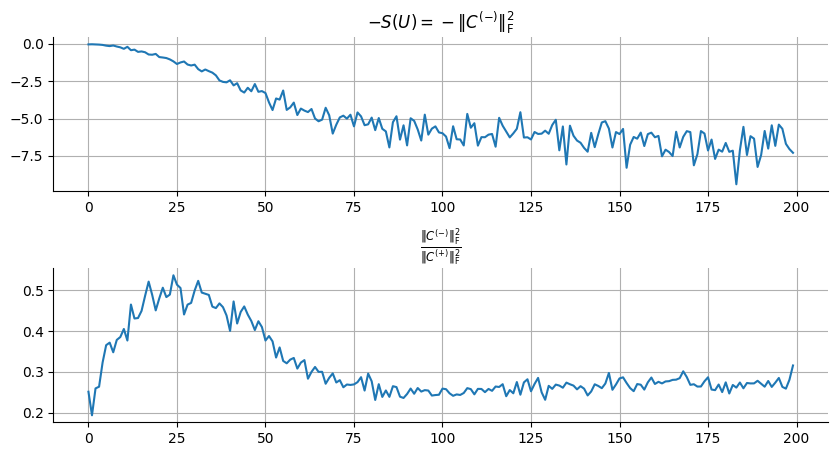

In [91]:
from kernel_sca_inducing_points import *
kernel_function=K_X_Y_squared_exponential
d = 3
c = 30
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=200, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )

In [82]:
def analyse_projs(Y, ymin = -1, ymax=1):
    K, _, _ = Y.shape
    # thresholds = jnp.floor(jnp.mean(RTs, axis=0)).astype(int)
    # for i, idx in enumerate(thresholds):
    #     Y = Y.at[i, :, idx:].set(jnp.nan)


    #plot_3D_K_coded(Y, rotate=True, azimuth=80, elevation=15)

    plt.figure()
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    cmap = plt.get_cmap('coolwarm', K)
    for k in range(Y.shape[0]):
        color = cmap(k / (K - 1)) 
        axs[0].plot(Y[k, 0, :], color=color)
        axs[1].plot(Y[k, 1, :], color=color)
        axs[2].plot(Y[k, 2, :], color=color)

    for ax in axs:
        ax.set_ylim(ymin, ymax)

Text(0.5, 0.92, 'kSCA; s = 0.2600424289703369')

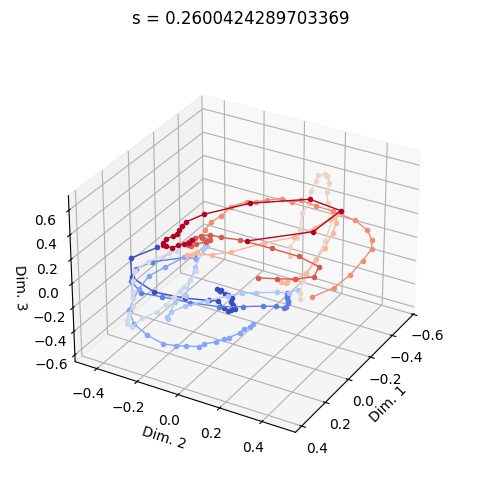

<Figure size 640x480 with 0 Axes>

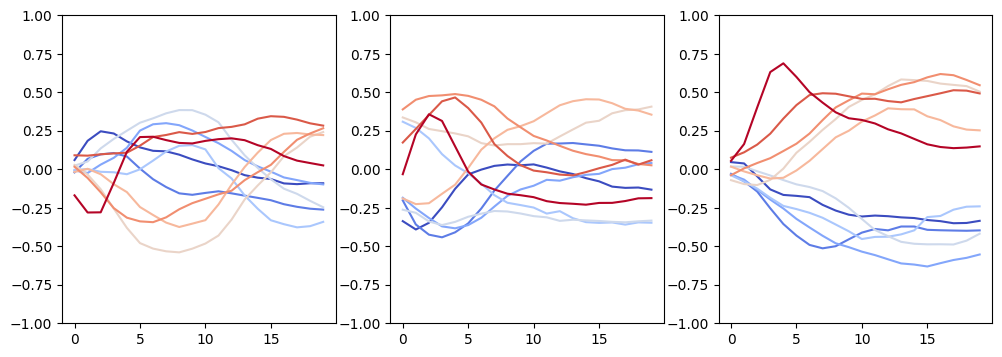

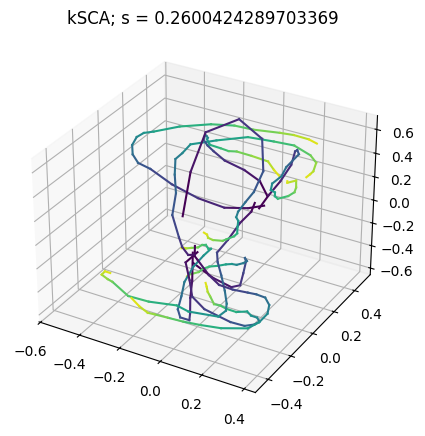

In [92]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, _, _, _ , _ = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)[:,:,:]

plot_3D_K_coded(Y, rotate=True)

analyse_projs(Y)

plot_3D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')


Iteration 0, S: 137.6416015625, S_ratio: 0.0019225811120122671
Iteration 10, S: 272.57598876953125, S_ratio: 0.002856970764696598
Iteration 20, S: 161.82398986816406, S_ratio: 0.0014517451636493206
Iteration 30, S: 331.0271911621094, S_ratio: 0.0028542226646095514
Iteration 40, S: 460.17279052734375, S_ratio: 0.0035712472163140774
Iteration 50, S: 1023.70556640625, S_ratio: 0.0076006874442100525
Iteration 60, S: 664.4159545898438, S_ratio: 0.005472281482070684
Iteration 70, S: 961.1007690429688, S_ratio: 0.0070624095387756824
Iteration 80, S: 718.6047973632812, S_ratio: 0.0066543095745146275
Iteration 90, S: 1325.6639404296875, S_ratio: 0.011667745187878609
Iteration 100, S: 875.615966796875, S_ratio: 0.006916562560945749
Iteration 110, S: 986.598388671875, S_ratio: 0.008271806873381138
Iteration 120, S: 1198.419189453125, S_ratio: 0.009566627442836761
Iteration 130, S: 1105.19677734375, S_ratio: 0.009045095182955265
Iteration 140, S: 776.511962890625, S_ratio: 0.007385497447103262
Ite

Text(0.5, 0.92, 'SCA; s = 0.006605359259992838')

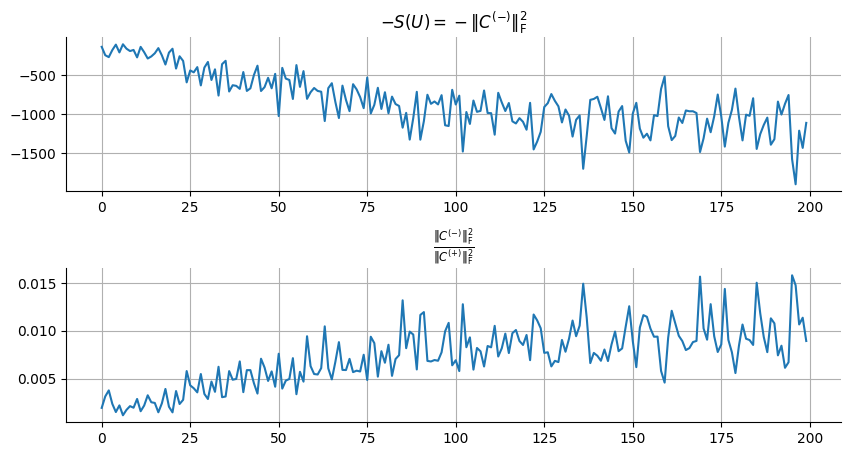

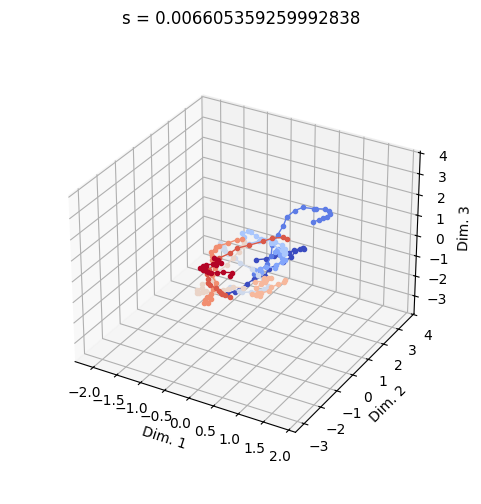

<Figure size 640x480 with 0 Axes>

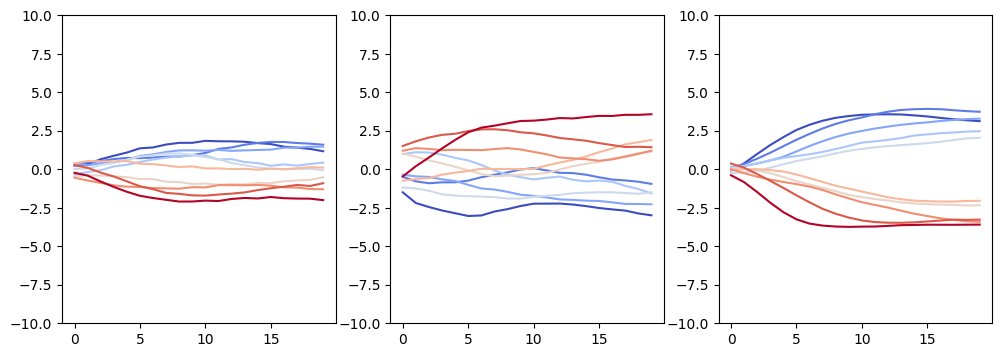

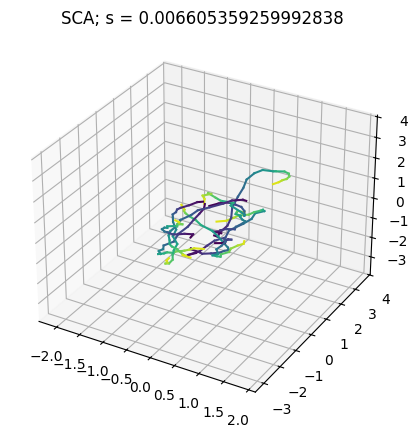

In [93]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X), d=d, learning_rate=0.01, iterations=200) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X))


# for i in range(Y.shape[0]):
#     #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
#     Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_3D_K_coded(Y)

analyse_projs(Y, ymin=-10, ymax=10)

plot_3D(Y[:,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

#analyse_projs(Y, RTs, ymin=-2, ymax=2)

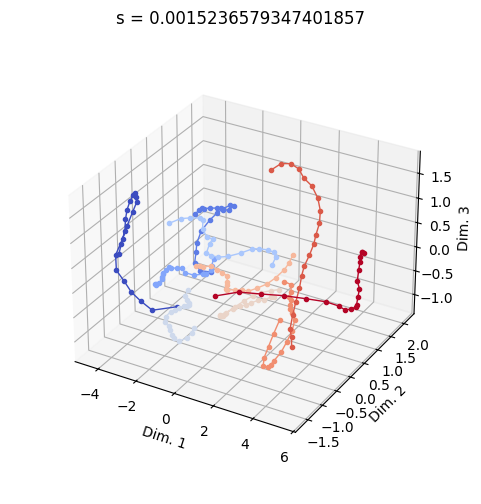

<Figure size 640x480 with 0 Axes>

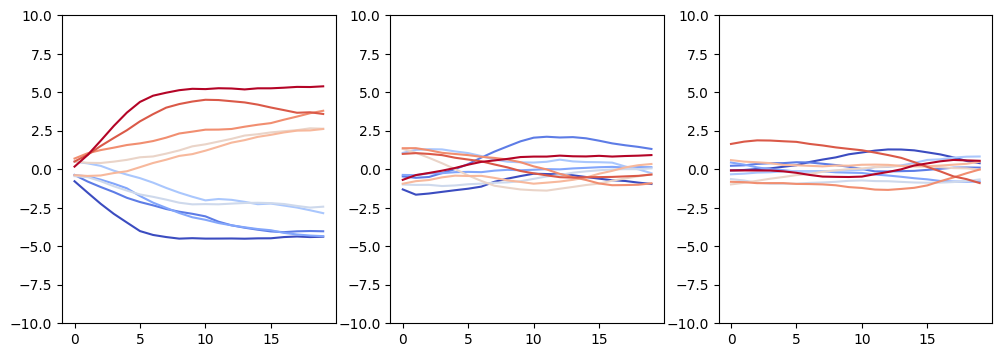

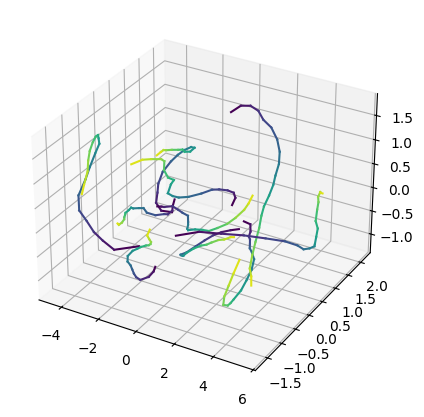

In [94]:
Y_pca, PCs = get_pca(center(X), num_pcs=d)

# for i in range(Y_pca.shape[0]):
#     Y_pca = Y_pca[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_3D_K_coded(jnp.array(Y_pca))

analyse_projs(Y_pca, ymin=-10, ymax=10)

plot_3D(Y_pca)